In [94]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.pyplot import rc_context

In [95]:
sc.set_figure_params(dpi=100, color_map = 'viridis_r')


In [96]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)


In [97]:
#sc.logging.print_header()

In [98]:
results_file = '/data/Parent_SC3v3_Human_Glioblastoma/Result-matrix.h5ad'  # the file that will store the analysis results

In [99]:
adata = sc.read_10x_mtx(
    'data/Parent_SC3v3_Human_Glioblastoma/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
     var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
     cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-Parent_SC3v3_Human_Glioblastoma-filtered_feature_bc_matrix-matrix.h5ad


In [100]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [101]:
adata

AnnData object with n_obs × n_vars = 5604 × 36601
    var: 'gene_ids', 'feature_types'

In [102]:
print(type(adata))
df = adata.to_df()
if len(np.unique(df.columns)) != df.shape[1]:
    print('Non unique column (gene) names')
#df

<class 'anndata._core.anndata.AnnData'>


normalizing counts per cell
    finished (0:00:00)


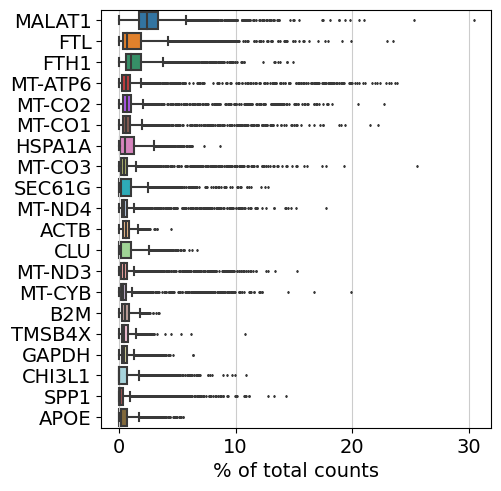

In [103]:
#Preprocessing; Show those genes that yield the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(adata, n_top=20, )

In [104]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 98 cells that have less than 200 genes expressed
filtered out 12238 genes that are detected in less than 3 cells


In [105]:
# QC using mitochondrial genes - High proportions are indicative of poor-quality cells possibly because 
#  of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger
# than individual transcript molecules and less likely to escape through tears in the cell membrane
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'feature_types' as categorical


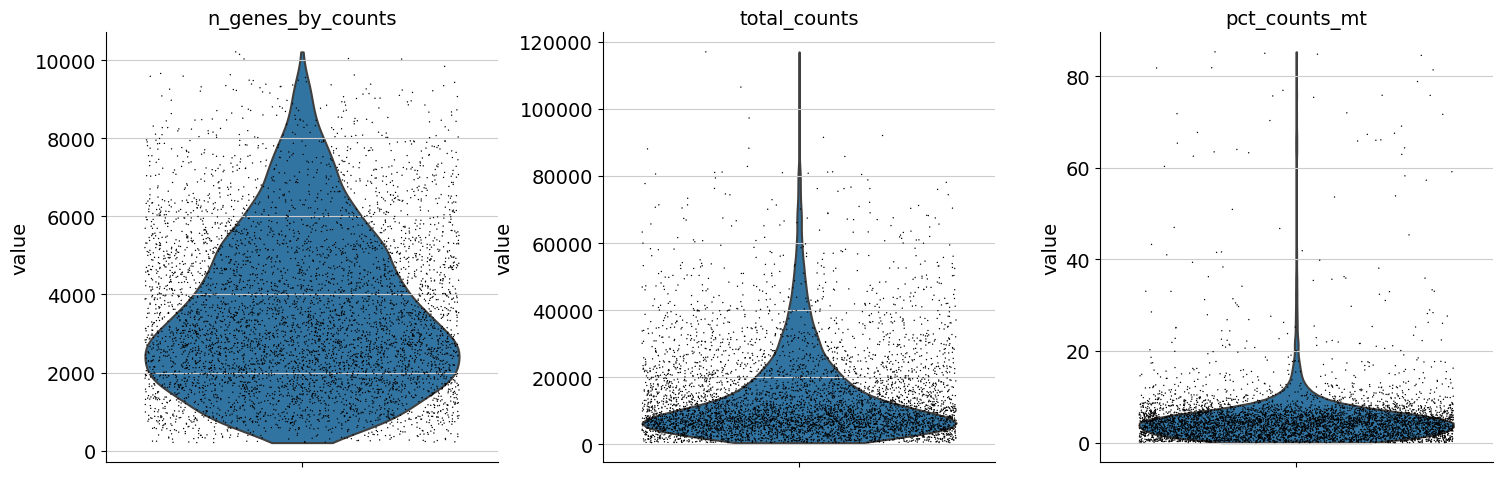

In [106]:
# Compute quality measures
# the number of genes expressed in the count matrix
# the total counts per cell
# the percentage of counts in mitochondrial genes
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

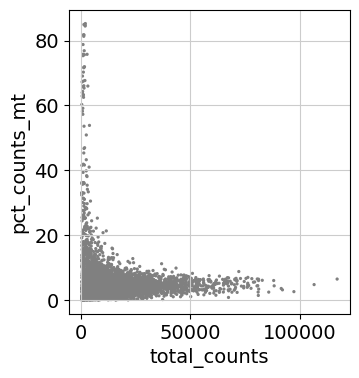

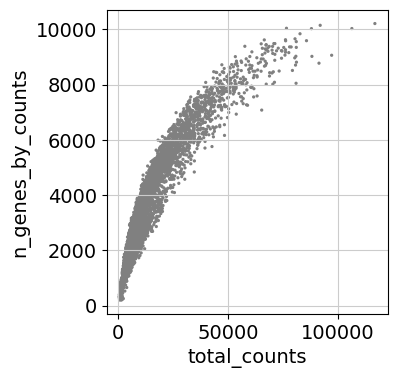

In [107]:
#Remove cells that have too many mitochondrial genes expressed or too many total counts:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [108]:
# Filtering by sclicing the anndata object
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [109]:
#Normalise the data
#Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [110]:
#Log-normalise the data
sc.pp.log1p(adata)

In [111]:
#Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


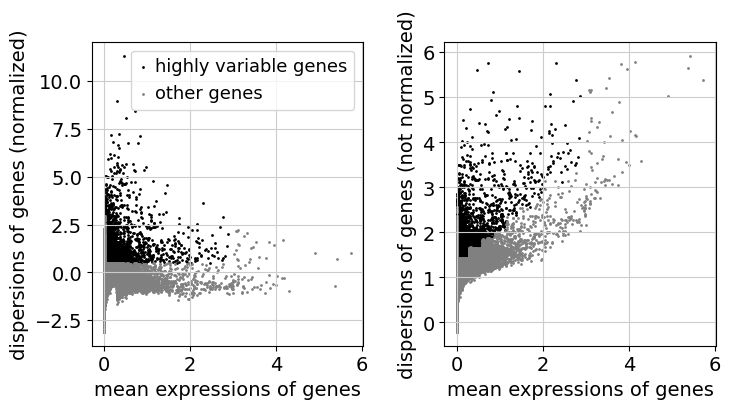

In [112]:
sc.pl.highly_variable_genes(adata)

In [113]:
#Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use 
#in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object
adata.raw = adata

In [114]:
#Filtering
adata = adata[:, adata.var.highly_variable]

In [115]:
#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. 
# Scale the data to unit variance.
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)


In [116]:
adata

AnnData object with n_obs × n_vars = 1047 × 4618
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [117]:
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

In [118]:
#PCA analysis
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


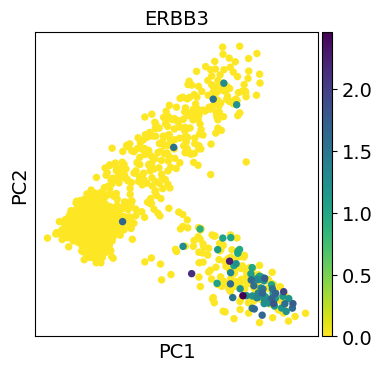

In [119]:
sc.pl.pca(adata, color='ERBB3')


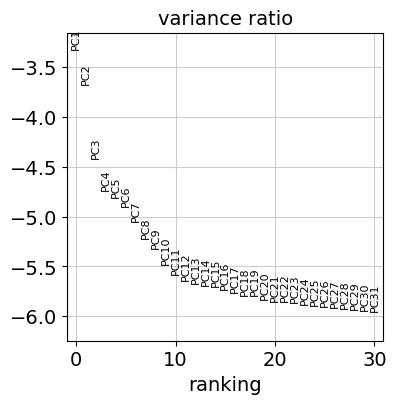

In [120]:
#Inspecting the contribution of single PCs to the total variance in the data. This gives us information about how many 
# PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function 
#sc.tl.louvain() or tSNE sc.tl.tsne()
sc.pl.pca_variance_ratio(adata, log=True)

In [121]:
#adata.write(results_file)

In [122]:
adata.obs_names_make_unique(); sc.pp.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


In [123]:
adata_eucl  = sc.pp.neighbors(adata, knn=False, method="gauss", copy=True)
adata_spear = sc.pp.neighbors(adata, knn=False, method="gauss", copy=True, metric="correlation")

#assert np.all(adata_eucl.uns["neighbors"]["connectivities"] == adata_spear.uns["neighbors"]["connectivities"])

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [124]:
#sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) - throwing error
sc.pp.neighbors(adata, method="gauss", knn=False)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [125]:
from scvelo.pp import neighbors
adata

AnnData object with n_obs × n_vars = 1047 × 4618
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [126]:
#!pip install hnswlib

In [127]:
#neighbors(adata, n_neighbors = 20, use_rep = "X",knn = True,random_state = 0,method = 'gauss',metric = "euclidean")

In [128]:
#sc.tl.umap(adata)

In [129]:
sc.tl.tsne(adata, perplexity=30, learning_rate=1000, random_state=0)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:02)


In [136]:
sc.tl.leiden(adata, key_added = "leiden_1.0") # default resolution in 1.0
sc.tl.leiden(adata, resolution = 0.6, key_added = "leiden_0.6")
sc.tl.leiden(adata, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata, resolution = 1.4, key_added = "leiden_1.4")

running Leiden clustering
    finished: found 6 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_1.4', the cluster labels (adata.obs, categorical) (0:00:02)


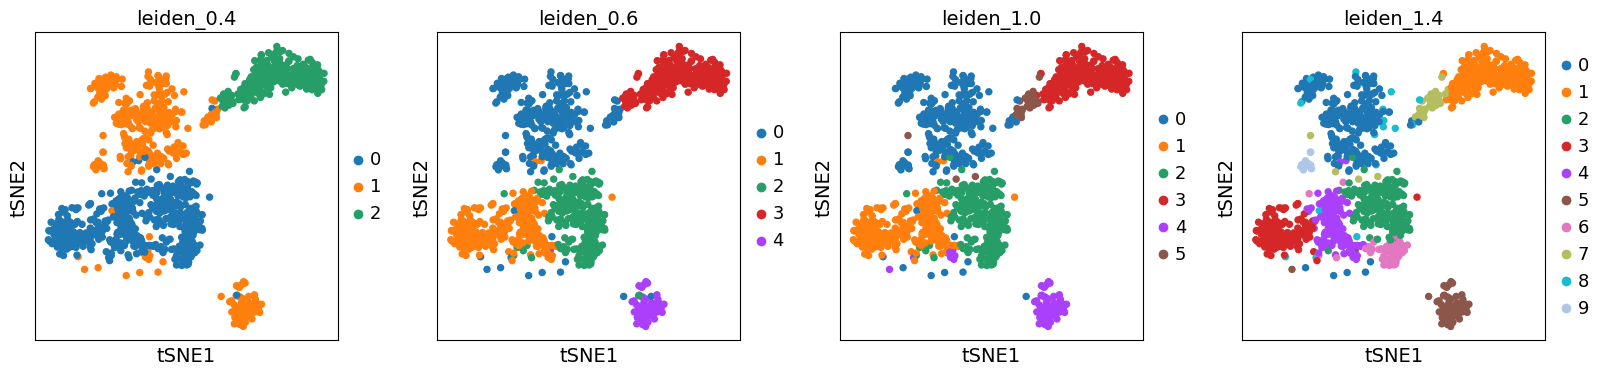

In [137]:
sc.pl.tsne(adata, color=['leiden_0.4', 'leiden_0.6', 'leiden_1.0','leiden_1.4'])

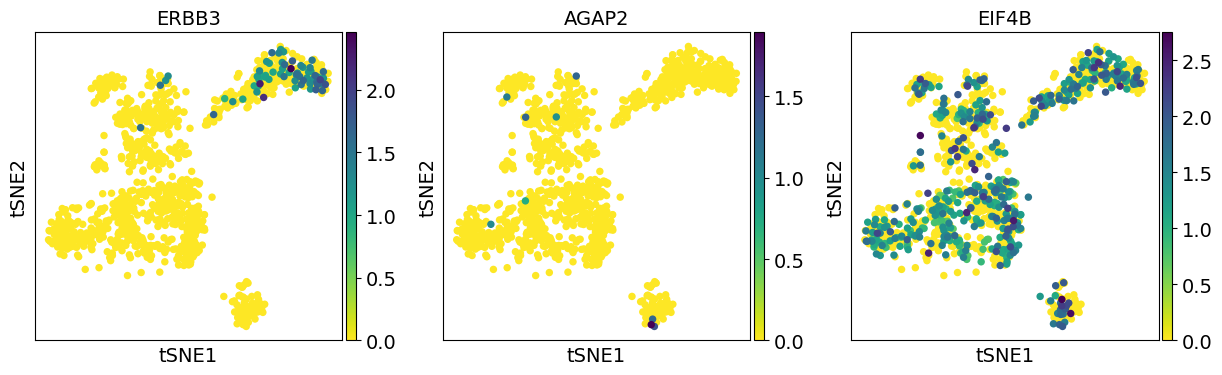

In [138]:
sc.pl.tsne(adata, color=[ 'ERBB3', 'AGAP2', 'EIF4B'])

In [176]:
#Identifying clusters based on known markers
markers = {
    'B-cell': ['CD79A', 'MS4A1'],
    'Dendritic': ['FCER1A', 'CST3'],
    'Monocytes': ['FCGR3A'],
    'NK': ['GNLY', 'NKG7'],
    'Other': ['IGLL1'],
    'Plasma': ['IGJ'],
    'T-cell': ['CD3D'],
}

In [204]:
#Select plot with 5 clusters using leiden and store the results with the name `clusters`
sc.tl.leiden(adata, resolution = 0.6, key_added = "clusters")

running Leiden clustering
    finished: found 5 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:02)


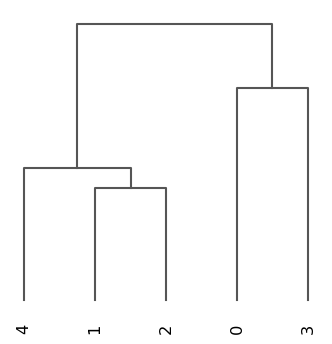

In [205]:
sc.pl.dendrogram(adata, groupby = "leiden_0.6")
markers = {'T-cell': ['CD3E', 'CD4', 'IL7R'], 
           'NK': ['GNLY', 'NKG7'],
           'Myeloid': ['CST3', 'CD14', 'CD68', 'FCGR3A'],
           'Astrocytes': ['GFAP', 'NCAM1', 'EGFR', 'APOE', 'SOX9', 'GAP43', 'AQP4'],
           'Oligodendrocytes': ['MOG', 'MBP', 'CNP', 'PLP1','S100B']}

#sc.pl.dotplot(adata, genes, groupby='leiden_0.6', dendrogram=True)
#sc.pl.dotplot(adata, 'clusters', marker_genes_dict, groupby='leiden_0.6', dendrogram=True)

categories: 0, 1, 2, etc.
var_group_labels: T-cell, NK, Myeloid, etc.


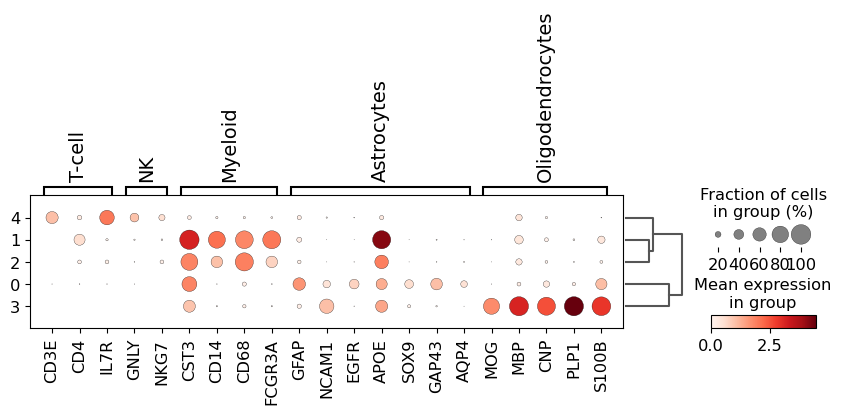

In [206]:
sc.pl.dotplot(adata, markers, groupby='leiden_0.6', dendrogram=True)
#sc.pl.dotplot(adata, genes, groupby='leiden_0.6', dendrogram=True)
#sc.pl.dotplot(adata, 'clusters', marker_genes_dict, groupby='leiden_0.6', dendrogram=True)

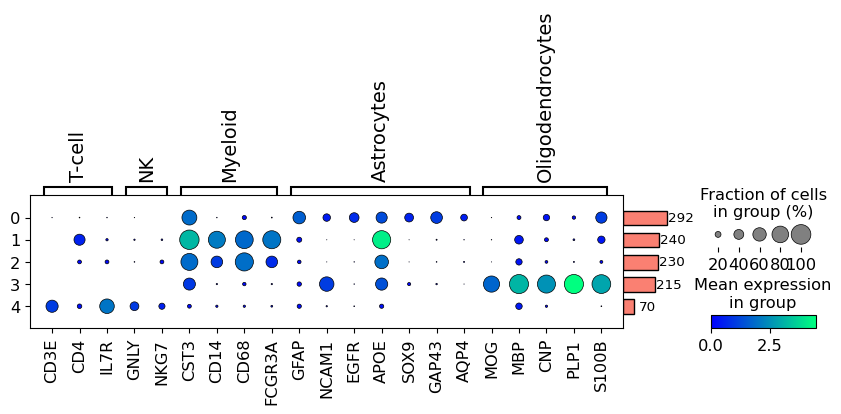

In [207]:
dp = sc.pl.dotplot(adata, markers, groupby='leiden_0.6', return_fig=True)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

In [208]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Astrocytes',
     '1': 'Macrophages',
     '2': 'Monocytes',
     '3': 'Oligodendrocytes',
     '4': 'T-cell/NK',
}

In [209]:
adata.obs['cell type'] = adata.obs['clusters'].map(cluster2annotation).astype('category')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell type']`
categories: Astrocytes, Macrophages, Monocytes, etc.
var_group_labels: T-cell, NK, Myeloid, etc.


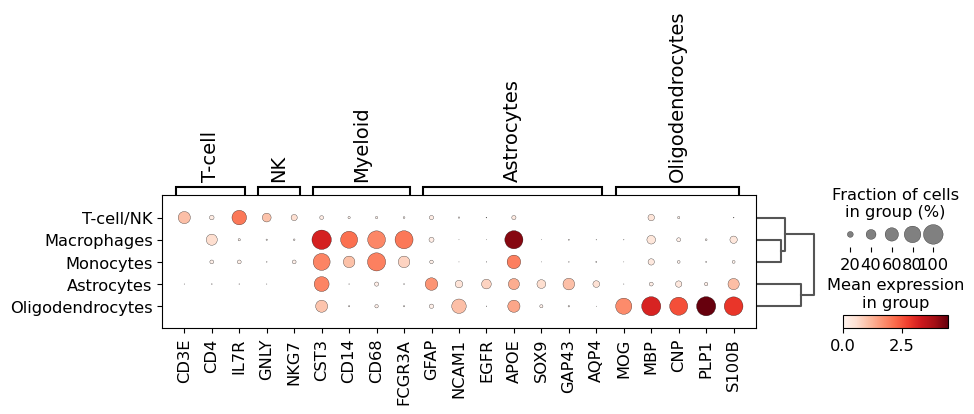

In [214]:
sc.pl.dotplot(adata, markers, 'cell type', dendrogram=True)

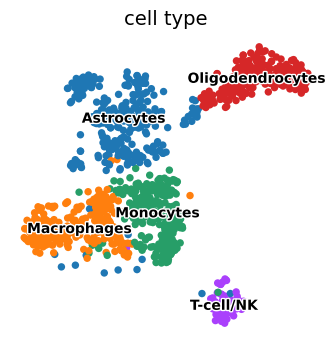

In [217]:
sc.pl.tsne(adata, color='cell type', legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

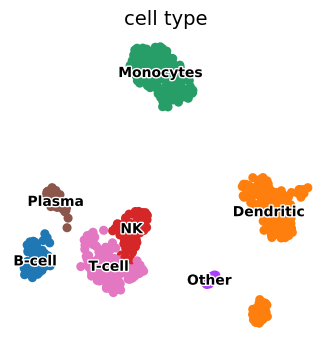

In [70]:
sc.pl.umap(pbmc, color='cell type', legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

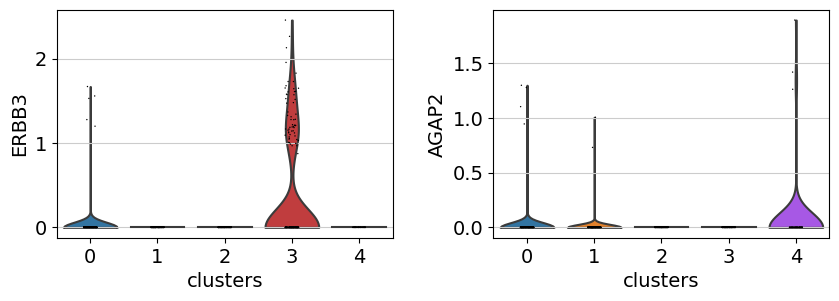

In [219]:
#violin plot
with rc_context({'figure.figsize': (4.5, 3)}):
    sc.pl.violin(adata, ['ERBB3', 'AGAP2'], groupby='clusters' )

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`
categories: 0, 1, 2, etc.
var_group_labels: T-cell, NK, Myeloid, etc.


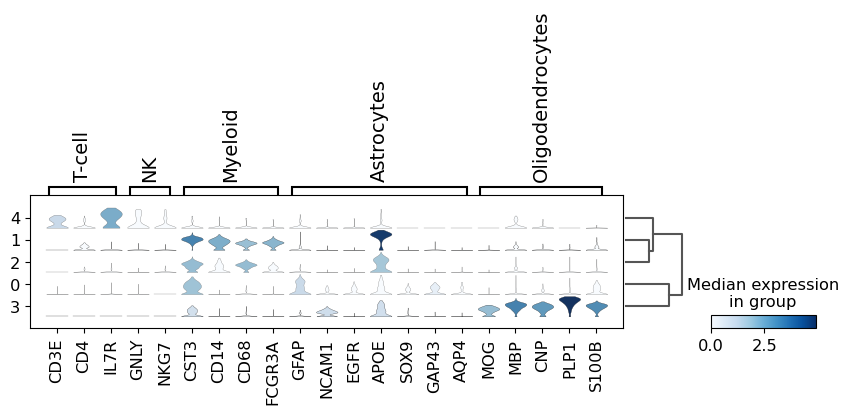

In [221]:
#stacked violin plot
ax = sc.pl.stacked_violin(adata, markers, groupby='clusters', swap_axes=False, dendrogram=True)

categories: 0, 1, 2, etc.
var_group_labels: T-cell, NK, Myeloid, etc.


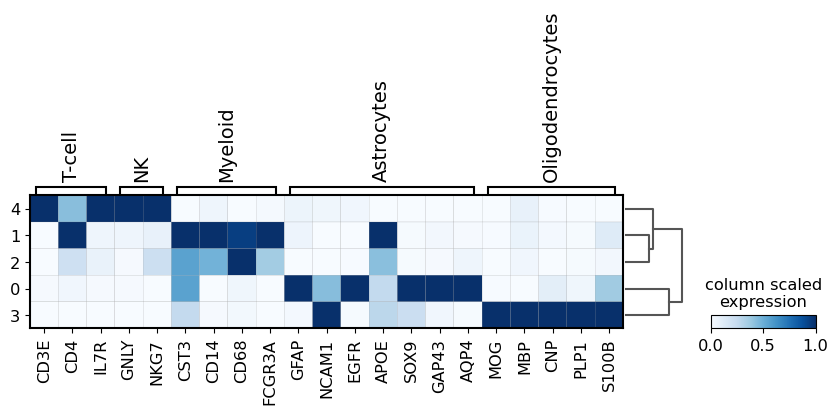

In [254]:
#Matrix plot
sc.pl.matrixplot(adata, markers, 'clusters', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')

categories: 0, 1, 2, etc.
var_group_labels: T-cell, NK, Myeloid, etc.


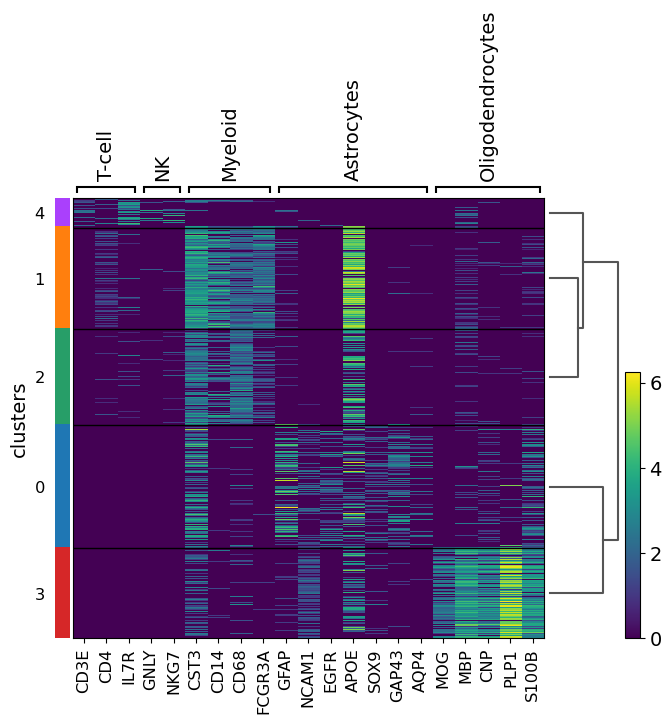

In [264]:
ax = sc.pl.heatmap(adata, markers, groupby='clusters', cmap='viridis', dendrogram=True)

categories: 0, 1, 2, etc.
var_group_labels: T-cell, NK, Myeloid, etc.


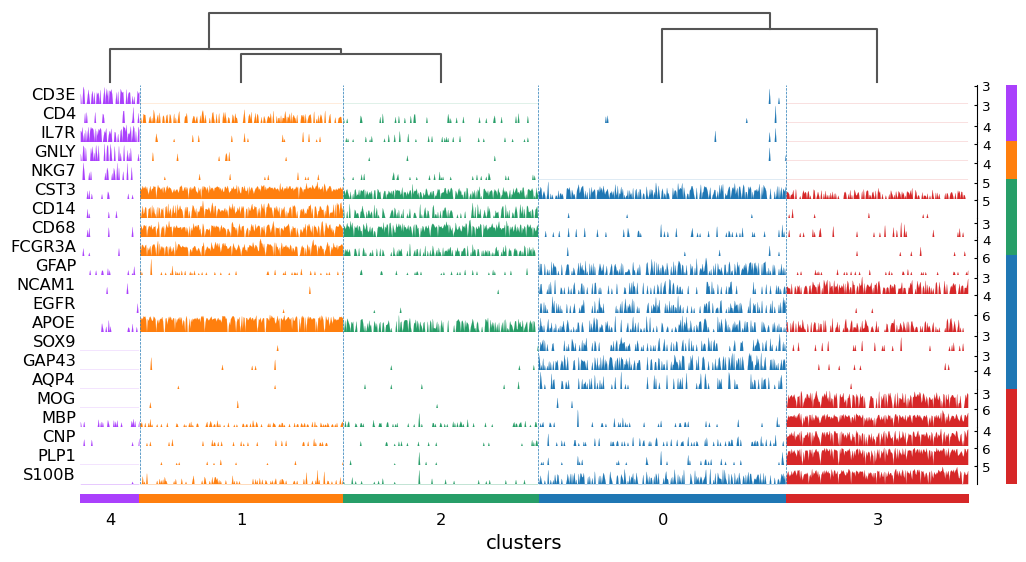

In [270]:
#Tracksplot: shows the same information as the heatmap, but, instead of a color scale, the gene expression is 
#represented by height.
ax = sc.pl.tracksplot(adata, markers, groupby='clusters', dendrogram=True)

In [271]:
#visualizing the differntially expressed marker genes as a dot plot
sc.tl.rank_genes_groups(adata, groupby='clusters', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


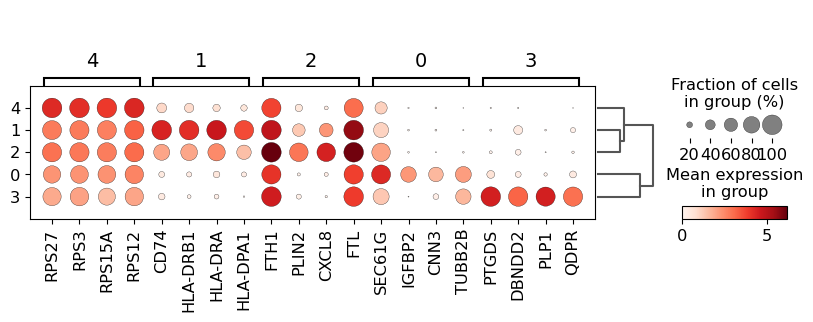

In [272]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4)

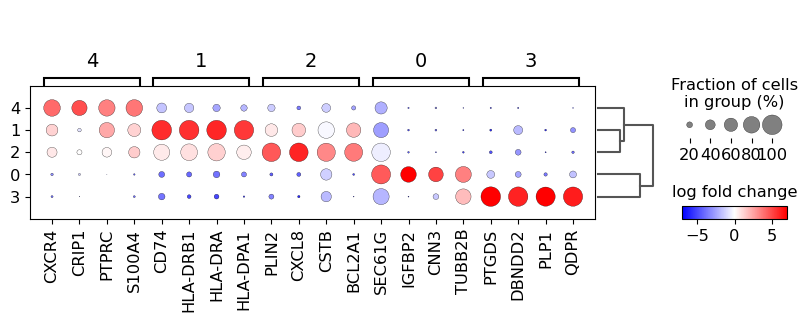

In [273]:
#Divergent color dotplot
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')

categories: 0, 1, 2, etc.
var_group_labels: 0, 3


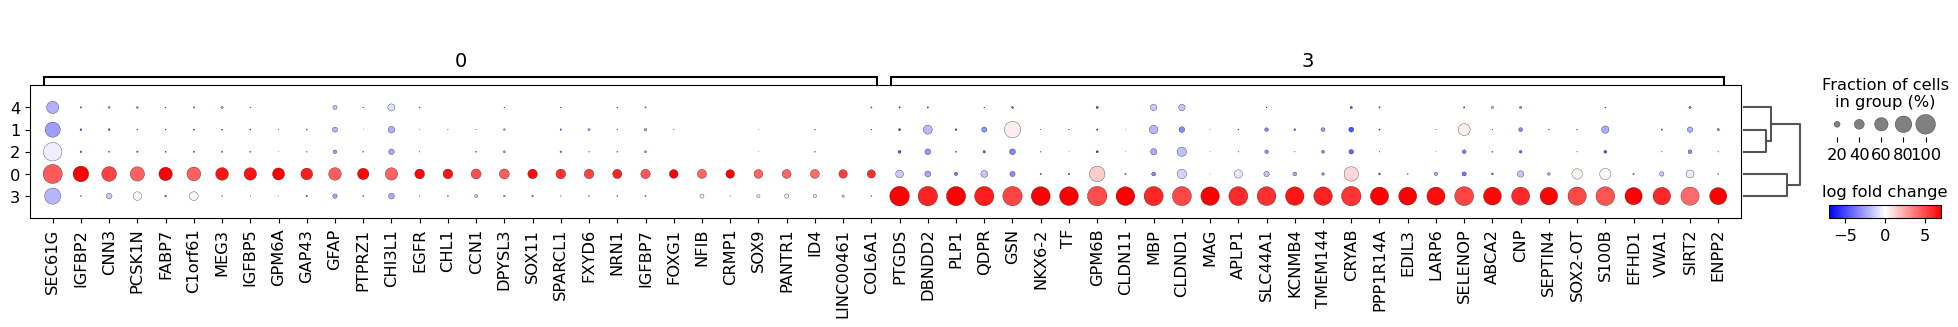

In [274]:
#Focusing on particular groups - astrocytes and oligodendrocytes)
#Here, we set n_genes=30 as in this case it will show all the genes that have a min_logfoldchange=4 up to 30
sc.pl.rank_genes_groups_dotplot(adata, n_genes=30, values_to_plot='logfoldchanges', min_logfoldchange=4, vmax=7, vmin=-7, cmap='bwr', groups=['0', '3'])

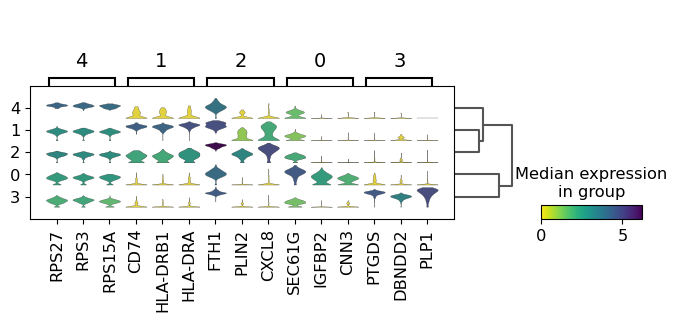

In [275]:
#visualize marker genes using stacked violin plots
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=3, cmap='viridis_r')

In [276]:
#showing 10 genes per category, turning gene labels off and swapping the axes
sc.pl.rank_genes_groups_heatmap(pbmc, n_genes=10, use_raw=False, swap_axes=True, show_gene_labels=False,
                                vmin=-3, vmax=3, cmap='bwr')

NameError: name 'pbmc' is not defined

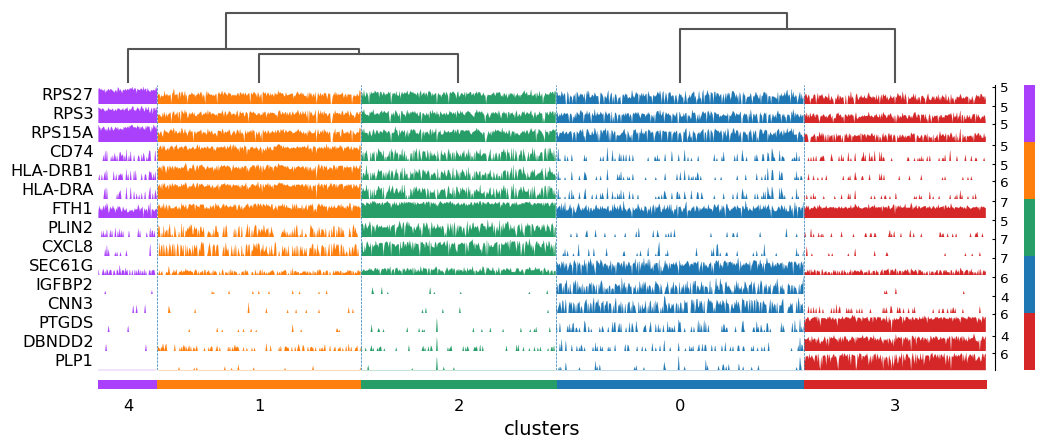

In [245]:
#visualize marker genes using traksplot
sc.pl.rank_genes_groups_tracksplot(adata, n_genes=3)